In [1]:
%%html
<style>
#notebook-container {width: 100%;}
.code_cell {flex-direction: row !important;}
.code_cell .output_wrapper {width: 50%;left: 0px;}
.code_cell .input {width: 50%;}
</style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.base import BaseEstimator
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, ShuffleSplit
from scipy.stats import spearmanr, norm, pearsonr
from scipy.linalg import pinv
%matplotlib inline
cycle = cycler(color=('#1f77b4', '#ff7f02', '#1f77b4', '#ff7f02'),
               linestyle=['-', '-', '--', '--'])


In [3]:
def simulate_data(X1, X2, source_noise=0, sensor_noise=0, corr=.8):
    np.random.seed(0)
    n = 1000
    Cx = np.array([[1, corr], [corr, 1.]])
    X = np.random.multivariate_normal(np.zeros(2), Cx, n)
    X = scale(X)
    F = np.random.randn(3, 3)
    F = F @ F.T  # to make it positive semi-definite
    Ys = list()
    Es = list()
    for x1, x2 in zip(X1, X2):
        M = np.diag([x1, x2])
        E = M != 0
        M = np.c_[M, np.zeros(2)]
        N = np.random.randn(n, len(M.T)) * source_noise
        N[:, :2] = 0
        Y = (X @ E @ M + N) @ F
        Y += np.random.randn(*Y.shape) * sensor_noise
        Ys.append(Y)
        Es.append(E)    
    Y = scale(Y)
    Ys.append(Y)
    return X, np.array(Ys), np.array(Es)


alphas = np.logspace(-5, 5, 12)

class JR(BaseEstimator):
    def __init__(self, n_splits=2,
                 G=RidgeCV(alphas=alphas,fit_intercept=False),
                 H=RidgeCV(alphas=alphas,fit_intercept=False)):
        self.G = G
        self.H = H
        self.n_splits = n_splits

    def fit(self, Y, X):
        ensemble = ShuffleSplit(n_splits=self.n_splits, test_size=.5)
        H_hats = list()
        self.alpha_ = list()
        for G_set, H_set in ensemble.split(Y, X):
            X_hat = self.G.fit(Y[G_set], X[G_set]).predict(Y)
            H_hat = self.H.fit(X[H_set], X_hat[H_set]).coef_
            self.alpha_.append(self.H.alpha_)
            H_hats.append(H_hat)
        self.alpha_ = np.mean(self.alpha_)
        self.E_ = np.mean(H_hats, 0)
        
        # for decoding predictions
        # alpha = 1e-2
        # self.coef_ = self.G.fit(Y, X).coef_.T @ pinv(E.T + alpha*np.eye(len(E)))
        self.coef_ = pinv(X.T @ Y) @ (X.T @ X)            

        return self
    
    def predict(self, Y):
        return Y @ self.coef_


class Clement(BaseEstimator):
    """Similar to predDecor but clean"""

    def __init__(self, alpha=.8):
        self.alpha = alpha

    def fit(self, Y, X):
        assert X.shape[1] == 2
        ridge = Ridge(alpha=self.alpha)
        X_hat = ridge.fit(Y, X).predict(Y)

        (x12, x21), (x11, x22) = X_hat.T @ X

        X_corr = np.c_[X[:, 0] - X[:, 1] * x21/x22,
                       X[:, 1] - X[:, 0] * x11/x12]

        self.decod_ = ridge.fit(Y, X_corr)

    def predict(self, Y):
        return self.decod_.predict(Y)

In [4]:
def cv_score(model, Y, X):
    cv = KFold(3)
    
    Rs = list()
    for train, test in cv.split(Y, X):
        model.fit(Y[train], X[train])
        X_hat = model.predict(Y[test])
        R = list()
        for x, x_hat in zip(X[test].T, X_hat.T):
            r = pearsonr(x, x_hat)[0]
            R.append(r)
        Rs.append(R)
    return np.mean(Rs, 0)

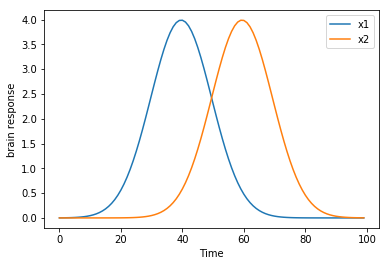

In [5]:
# Ground truth
n_times = 100
time = np.linspace(0, 1, n_times)
X1 = norm.pdf(time, .4, .1)
X2 = norm.pdf(time, .6, .1)

plt.plot(X1, label='x1')
plt.plot(X2, label='x2')
plt.xlabel('Time')
plt.ylabel('brain response')
plt.legend()

In [6]:
# Simulate noisy data
hypotheses, meg, Es = simulate_data(X1, X2,
                                    source_noise=1e2,
                                    sensor_noise=1e0,# change this for fun
                                    corr=.8) # change this for fun
Ys = meg
X = hypotheses

Text(0,0.5,'Decoding R score')

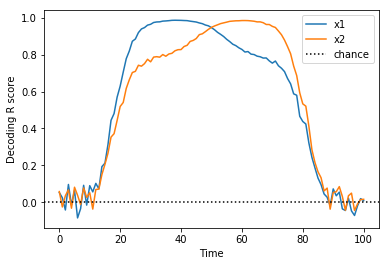

In [7]:
method = RidgeCV(alphas)
decod_no_noise = [cv_score(method, Y, X) for Y in Ys]

plt.plot(decod_no_noise)
plt.axhline(0, color='k', ls=':')
plt.legend(['x1', 'x2', 'chance'])
plt.xlabel('Time')
plt.ylabel('Decoding R score')

Text(0,0.5,'E')

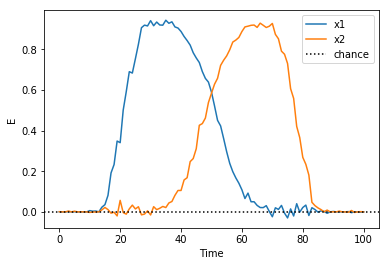

In [8]:
method = JR()
jr = [np.diag(method.fit(Y, X).E_) for Y in Ys]

plt.plot(jr)
plt.axhline(0, color='k', ls=':')
plt.legend(['x1', 'x2', 'chance'])
plt.xlabel('Time')
plt.ylabel('E')

Text(0,0.5,'JR Corrected Decoding R score')

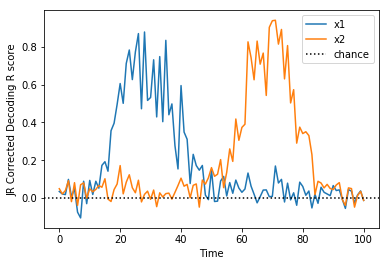

In [9]:
# Using decoding prediction instead
method = JR()
jr = [cv_score(method, Y, X) for Y in Ys]

plt.plot(jr)
plt.axhline(0, color='k', ls=':')
plt.legend(['x1', 'x2', 'chance'])
plt.xlabel('Time')
plt.ylabel('JR Corrected Decoding R score')

Text(0,0.5,'Clem Corrected Decoding R score')

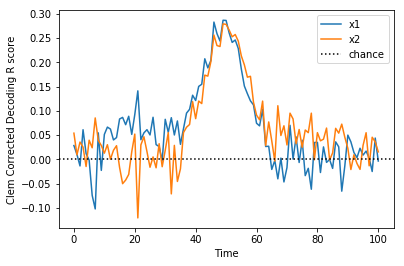

In [10]:
method = Clement()
clem = [cv_score(method, Y, X) for Y in Ys]

plt.plot(clem)
plt.axhline(0, color='k', ls=':')
plt.legend(['x1', 'x2', 'chance'])
plt.xlabel('Time')
plt.ylabel('Clem Corrected Decoding R score')

Text(0,0.5,'Clem Corrected Decoding R score')

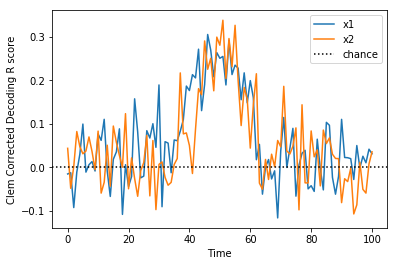

In [11]:
# just to check that I didn't screw up clem's method when I cleaned it
cv = ShuffleSplit(1, test_size=.5)

def predDecor(x1, Y, x2, alpha):
    """Clem partial regression"""
    scores = list()
    for train, test in cv.split(Y, x1):
        d = Y.shape[1]
        S = np.dot(Y[train].T, Y[train])
        S1 = np.dot(Y[train].T, x1[train])
        S2 = np.dot(Y[train].T, x2[train])
        R = pinv(S+alpha*np.diag(np.ones(d)))
        if norm(S2) == 0:
            w = np.dot(R, S1)
            pred = np.dot(Y[test], w)
        else:
            ell = -np.dot(S2.T, np.dot(R, S1))/np.dot(S2.T, np.dot(R, S2))
            w = np.dot(R, S1+ell*S2)
            pred = np.dot(Y[test], w)
        score, _ = spearmanr(pred, x1[test])
        scores.append(score)
    return scores


clem = np.squeeze([
    [predDecor(X[:, 0], Y, X[:, 1], 2) for Y in Ys],
    [predDecor(X[:, 1], Y, X[:, 0], 2) for Y in Ys]
]).T

plt.plot(clem)
plt.axhline(0, color='k', ls=':')
plt.legend(['x1', 'x2', 'chance'])
plt.xlabel('Time')
plt.ylabel('Clem Corrected Decoding R score')